In [489]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import glob
import json
import pandas as pd

## Transcript parsing and dataset creation 

In [256]:
def parse_line(line):
    character, text = line.split(':', 1)
    return character.strip().lower(), text.strip()

In [263]:
def clean_text(text):
    text = re.sub(r'---\s?', '', text)
    text = re.sub(r'\(.*\)\s?', '', text)
    text = re.sub(r'♪\s?', '', text)
    return text

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
def separate_sentences(text):
    return sent_detector.tokenize(text)

In [260]:
main_characters = {'bart', 'lisa', 'marge', 'homer'}
def parse_episode(filename, handle_multiline=True, main_characters=main_characters):
    transcript = ''
    character_lines = {character: [] for character in main_characters}
    
    with open(filename) as file:
        transcript = file.read()
    
    lines = iter(transcript.split('\n'))
    for line in lines:
        line = line.strip()
        if line == '':
            continue
        # Non-dialogue line
        if line.find(':') == -1:
            continue
            
        character, text = parse_line(line)
    
        if character not in main_characters:
            continue
            
        # Single line dialogue
        if text != '':
            for sentence in separate_sentences(clean_text(text)):
                character_lines[character].append(sentence)
        # Multi line dialogue
        elif handle_multiline:
            for i, subline in enumerate(lines):
                # Multiline dialogues start and end with an empty line
                if i == 0 and subline == '':
                    continue
                if subline == '':
                    break
                for sentence in separate_sentences(clean_text(text)):
                    character_lines[character].append(sentence)
    return character_lines

In [380]:
ep_lines_array = [parse_episode(ep, handle_multiline=i>4) for i, ep in enumerate(glob.glob('./data/*.txt'))]

def combine_lines(ep_lines_array):
    res = {char: [] for char in main_characters}
    for ep_lines in ep_lines_array:
        for char in main_characters:
            res[char] += (ep_lines[char])
    return res

dataset = combine_lines(ep_lines_array)

In [ ]:
with open('./data/dataset.json', 'w') as file:
    json.dump(dataset, file)

## Model testing

In [104]:
def flatten(list_of_lists):
    return [el for list in list_of_lists for el in list]

In [445]:
def preprocess(data):
    data = data.toarray()
    sum = data.sum(axis=1)
    freq = (data/sum).ravel() if sum != 0 else np.array([0])
    return dict(enumerate(freq.ravel()))

def extract_features(bag, line):
    return preprocess(bag.transform([line]))

In [417]:
bag = CountVectorizer()
bag.fit(flatten(dataset.values()))

X = [(preprocess(line), character) for character in main_characters for line in bag.transform(dataset[character])]
bayes = nltk.NaiveBayesClassifier.train(X)

print(len(bag.get_feature_names_out()))

2614


In [437]:
stemmer = nltk.stem.PorterStemmer()

bag = CountVectorizer(tokenizer=lambda x: [stemmer.stem(word) for word in nltk.word_tokenize(x)], token_pattern=None)
bag.fit(flatten(dataset.values()))

X = [(preprocess(line), character) for character in main_characters for line in bag.transform(dataset[character])]
bayes = nltk.NaiveBayesClassifier.train(X)

print(len(bag.get_feature_names_out()))

2326


In [428]:
lemmer = nltk.stem.WordNetLemmatizer()

bag = CountVectorizer(tokenizer=lambda x: [lemmer.lemmatize(word) for word in nltk.word_tokenize(x)], token_pattern=None)
bag.fit(flatten(dataset.values()))

X = [(preprocess(line), character) for character in main_characters for line in bag.transform(dataset[character])]
bayes = nltk.NaiveBayesClassifier.train(X)

print(len(bag.get_feature_names_out()))

2552


In [446]:
stemmer = nltk.stem.SnowballStemmer(language='english')

bag = CountVectorizer(tokenizer=lambda x: [stemmer.stem(word) for word in nltk.word_tokenize(x)], token_pattern=None)
bag.fit(flatten(dataset.values()))

X = [(preprocess(line), character) for character in main_characters for line in bag.transform(dataset[character])]
bayes = nltk.NaiveBayesClassifier.train(X)

print(len(bag.get_feature_names_out()))

2319


In [460]:
stemmer = nltk.stem.SnowballStemmer(language='english')

bag = CountVectorizer(tokenizer=lambda x: [stemmer.stem(word) for word in nltk.word_tokenize(x)], token_pattern=None, 
                      max_features=750)
bag.fit(flatten(dataset.values()))

X = [(preprocess(line), character) for character in main_characters for line in bag.transform(dataset[character])]
bayes = nltk.NaiveBayesClassifier.train(X)

print(len(bag.get_feature_names_out()))

750


## Validation on popular quotes

In [476]:
# Correct: Homer
bayes.classify(extract_features(bag, "If something's hard to do, then it's not worth doing"))

'homer'

In [477]:
# Correct: Homer
bayes.classify(extract_features(bag, "Marge it takes two to lie."))

'homer'

In [478]:
# Correct: Marge
bayes.classify(extract_features(bag, "I just think they're neat."))

'homer'

In [479]:
# Correct: Marge
bayes.classify(extract_features(bag, "I hope you understand I'm too tense to pretend I like you."))

'marge'

In [480]:
# Correct: Lisa
bayes.classify(extract_features(bag, "If anyone wants me I'll be in my room."))

'homer'

In [481]:
# Correct: Lisa
bayes.classify(extract_features(bag, "These are my only friends."))

'bart'

In [484]:
# Correct: Bart
bayes.classify(extract_features(bag, "I didn't do it."))

'bart'

In [483]:
# Correct: Bart
bayes.classify(extract_features(bag, "They're not gonna get away with this."))

'bart'

## Checking if the dataset is unbalanced

In [510]:
counts = pd.DataFrame({character: [len(dataset[character])] for character in dataset})
counts

,homer,bart,marge,lisa
0,1519,975,626,323


(-1.25, 1.25, -1.25, 1.25)

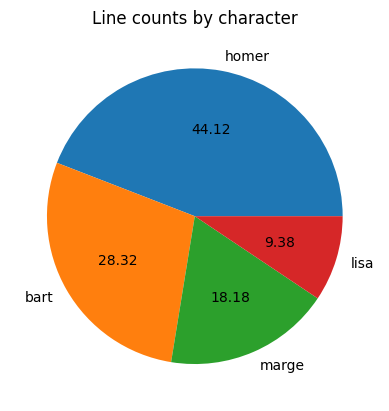

In [512]:
counts.T[0].plot.pie(title='Line counts by character', autopct='%.2f').axis('off')